In [1]:
! pip uninstall torch torchvision -y
! pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.5.1+cu101:
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 46.7MB/s 


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
import matplotlib
import pickle
import numpy
import platform

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(numpy.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import numpy as np

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))
print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

python version:      3.6.9
torch version:       1.4.0
torchvision version: 0.5.0
numpy version:       1.18.5
matplotlib version:  3.2.2
pickle version:      4.0
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4


Set CUDNN to deterministic for reproducibility reasons:

In [3]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mount GDrive:

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
base_url = '/content/gdrive/My Drive/neuralnet-patchinit/'

# Data

## Specify Dataset

Define data transform functions:

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Define training and test set:

In [7]:
# training set
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# test set
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Load Data

In [8]:
batch_size_train = 64  # https://github.com/BVLC/caffe/blob/master/examples/mnist/lenet_train_test.prototxt
batch_size_test = 1000

Create train and test data loader:

In [9]:
# create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=2
)

# create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=2
)

## Display Samples

In [10]:
def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        
        img = data * 0.3081 + 0.1307  # unnormalize
        plt.imshow(img[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(targets[i]))
        
        plt.xticks([])
        plt.yticks([])

Load a few test images and display them:

tensor shape: (1000, 1, 28, 28)


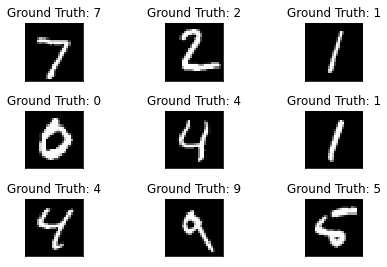

In [11]:
dataiter = enumerate(testloader)
_, (sample_data, sample_targets) = next(dataiter)

show_samples(sample_data, sample_targets)

# Define Training and Test Methods

In [12]:
def train(num_epochs, model, optim, crit, train_loader, test_loader):
    train_losses = []
    test_losses = []
    test_accs = []
    
    for epoch in range(1, num_epochs + 1):
        model, train_losses = train_one_epoch(epoch, model, optim, crit, train_loader, train_losses)
        test_losses, test_accs = test(model, crit, test_loader, test_losses, test_accs)
        
    print('Finished Training')
    return train_losses, test_losses, test_accs
    

def train_one_epoch(epoch_num, model, optim, crit, data_loader, losses):
    model.train()
    running_loss = 0.0
    
    for batch_idx, data in enumerate(data_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # zero the parameter gradients
        optim.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = crit(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            dataset_size = len(data_loader.dataset)
            used_samples = batch_idx * len(inputs)
            train_progress = 100. * batch_idx / len(data_loader)
            avg_batch_loss = running_loss / log_interval
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num, used_samples, dataset_size, train_progress, avg_batch_loss
            ))
            
            losses.append(avg_batch_loss)
            running_loss = 0.0
            
    return model, losses
     
    
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()
            
            # forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

# LeNet Architecture

LeNet (https://github.com/BVLC/caffe/blob/master/examples/mnist/lenet.prototxt):

In [13]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.fc1 = nn.Linear(800, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 800)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create Random Seed Values

Create 5 random numbers (between 0 and 99) for seed values:

In [14]:
#random_seed_list = np.random.choice(np.arange(100), 5)
#random_seed_list

In [15]:
#with open(base_url + "random-seeds.txt", "wb") as fp:
#  pickle.dump(random_seed_list, fp)

In [16]:
with open(base_url + "random-seeds.txt", "rb") as fp:
  random_seed_list = pickle.load(fp)

random_seed_list

array([76, 90, 32, 23, 12])

# Patch Init

## Create Patch based Weight Init

In [17]:
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

### Load Patches

In [18]:
def show_patches(patches):
    print("tensor shape: " + str(patches.shape))
    
    fig = plt.figure(figsize=(8,8))
    for i in range(patches.shape[0]):
        plt.subplot(5,4,i+1)
        plt.tight_layout()
        plt.imshow(patches[i], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])

Load data to get the patches:

In [19]:
patch_path = '/content/gdrive/My Drive/neuralnet-patchinit/mnist_kmeans/mnist_patches_avg_more_umap_kmeans2.txt'

with open(patch_path, "rb") as fp:
    patches = pickle.load(fp)

patches = patches.astype(np.float32)
patches.shape, patches.dtype

((20, 14, 14), dtype('float32'))

tensor shape: (20, 14, 14)


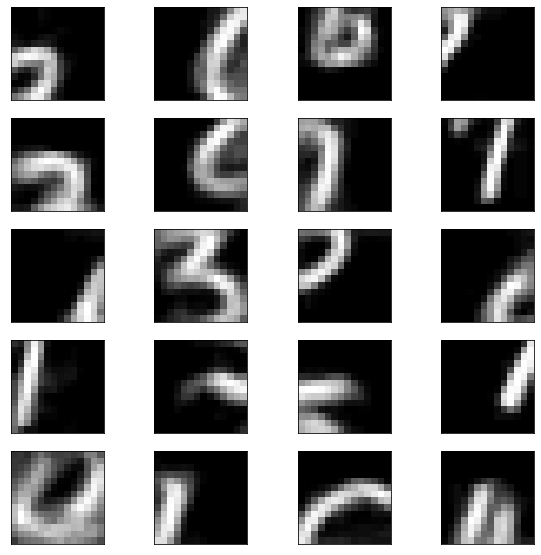

In [20]:
show_patches(patches)

### Remove Zeros

In [21]:
def remove_zeros(patches):
    mask = patches == 0.0
    n_null = np.sum(mask, axis=(1,2))
    a = np.sum(patches, axis=(1,2)) 
    
    for i in range(patches.shape[0]):
        p = patches[i]
        p[p == 0] = -1.0 * a[i] / n_null[i]
        patches[i] = p
        
    return patches

In [22]:
patches = remove_zeros(patches)

### Downsample Patches

In [23]:
patches = np.expand_dims(patches,1)
patches = torch.from_numpy(patches)
patches = F.interpolate(patches, size=5, mode='bilinear')

print("tensor shape: " + str(patches.shape))

tensor shape: torch.Size([20, 1, 5, 5])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


min value: -6.046029090881348
max value: 0.9700883030891418
tensor shape: torch.Size([20, 5, 5])


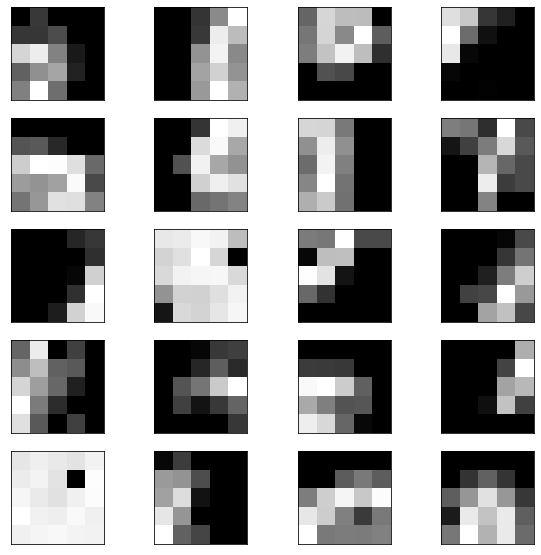

In [24]:
print("min value: " + str(torch.min(patches).item()))
print("max value: " + str(torch.max(patches).item()))
show_patches(patches.squeeze(1))

## Training

### Lr = 0.01

In [25]:
num_epochs = 20

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005

log_interval = 10

Create model and start training for each of the 5 seeds:

In [26]:
accs_patchinit_lr001_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-lr001-seed{}.txt".format(s)
    accs_patchinit_lr001_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.003060
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.009657
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.004663
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.007240
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.006978
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.001340
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.006542
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.002456
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.002280
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.010301
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.006920
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.007541
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.004977
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.006078
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.007491
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.007924
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.007623
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.008471
Train Epoch: 9 [53120/60000 (88%)

### Lr = 0.001

In [27]:
num_epochs = 20

learning_rate = 0.001
momentum = 0.9
weight_decay = 0.0005

log_interval = 10

Create model and start training for each of the 5 seeds:

In [28]:
accs_patchinit_lr0001_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-lr0001-seed{}.txt".format(s)
    accs_patchinit_lr0001_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.012291
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.019940
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.016648
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.018703
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.029987
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.007462
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.015525
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.015800
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.013472
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.016908
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.016736
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.019725
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.019499
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.018735
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.020410
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.022041
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.031581
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.024803
Train Epoch: 9 [53120/60000 (88%)

### Lr = 0.0001

In [29]:
num_epochs = 20

learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.0005

log_interval = 10

Create model and start training for each of the 5 seeds:

In [30]:
accs_patchinit_lr00001_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-lr00001-seed{}.txt".format(s)
    accs_patchinit_lr00001_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.087311
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.072670
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.052177
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.066302
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.075686
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.047323
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.070868
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.069204
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.080313
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.064387
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.058840
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.081461
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.068133
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.058393
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.064153
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.057335
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.079011
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.086378
Train Epoch: 9 [53120/60000 (88%)

### Lr = 0.00001

In [31]:
num_epochs = 20

learning_rate = 0.00001
momentum = 0.9
weight_decay = 0.0005

log_interval = 10

Create model and start training for each of the 5 seeds:

In [32]:
accs_patchinit_lr000001_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-lr000001-seed{}.txt".format(s)
    accs_patchinit_lr000001_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.266679
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.209628
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.191276
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.245788
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.254963
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.222311
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.237447
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.267809
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.248516
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.206314
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.215125
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.244196
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.240389
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.189216
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.218162
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.203532
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.250219
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.270146
Train Epoch: 9 [53120/60000 (88%)

# Results

In [33]:
def plot_results(results, names, stds, ymin):
    for i in range(len(results)):
        x = np.arange(len(results[i]))
        plt.errorbar(x, results[i], yerr=stds[i])
    
    plt.legend(names)
    plt.ylim(ymin, 100)
    plt.show()

Get results from kaiming uniform and patch init with lr = 0.01:

In [34]:
accs_sota_ukaim_lr001_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-lr001-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr001-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr001-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr001-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr001-seed12.txt',
]
accs_sota_ukaim_lr001_results = []

for p in accs_sota_ukaim_lr001_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_lr001_results.append(test_accs_tmp)

accs_sota_ukaim_lr001_results = np.array(accs_sota_ukaim_lr001_results)
avg_accs_sota_ukaim_lr001_results = np.mean(accs_sota_ukaim_lr001_results, axis=0)
std_accs_sota_ukaim_lr001_results = np.std(accs_sota_ukaim_lr001_results, axis=0)

In [35]:
accs_patchinit_lr001_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr001-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr001-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr001-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr001-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr001-seed12.txt',
]
accs_patchinit_lr001_results = []

for p in accs_patchinit_lr001_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_lr001_results.append(test_accs_tmp)

accs_patchinit_lr001_results = np.array(accs_patchinit_lr001_results)
avg_accs_patchinit_lr001_results = np.mean(accs_patchinit_lr001_results, axis=0)
std_accs_patchinit_lr001_results = np.std(accs_patchinit_lr001_results, axis=0)

Get results from kaiming uniform and patch init with lr = 0.001:

In [36]:
accs_sota_ukaim_lr0001_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-lr0001-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr0001-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr0001-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr0001-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr0001-seed12.txt',
]
accs_sota_ukaim_lr0001_results = []

for p in accs_sota_ukaim_lr0001_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_lr0001_results.append(test_accs_tmp)

accs_sota_ukaim_lr0001_results = np.array(accs_sota_ukaim_lr0001_results)
avg_accs_sota_ukaim_lr0001_results = np.mean(accs_sota_ukaim_lr0001_results, axis=0)
std_accs_sota_ukaim_lr0001_results = np.std(accs_sota_ukaim_lr0001_results, axis=0)

In [37]:
accs_patchinit_lr0001_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr0001-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr0001-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr0001-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr0001-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr0001-seed12.txt',
]
accs_patchinit_lr0001_results = []

for p in accs_patchinit_lr0001_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_lr0001_results.append(test_accs_tmp)

accs_patchinit_lr0001_results = np.array(accs_patchinit_lr0001_results)
avg_accs_patchinit_lr0001_results = np.mean(accs_patchinit_lr0001_results, axis=0)
std_accs_patchinit_lr0001_results = np.std(accs_patchinit_lr0001_results, axis=0)

Get results from kaiming uniform and patch init with lr = 0.0001:

In [38]:
accs_sota_ukaim_lr00001_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-lr00001-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr00001-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr00001-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr00001-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr00001-seed12.txt',
]
accs_sota_ukaim_lr00001_results = []

for p in accs_sota_ukaim_lr00001_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_lr00001_results.append(test_accs_tmp)

accs_sota_ukaim_lr00001_results = np.array(accs_sota_ukaim_lr00001_results)
avg_accs_sota_ukaim_lr00001_results = np.mean(accs_sota_ukaim_lr00001_results, axis=0)
std_accs_sota_ukaim_lr00001_results = np.std(accs_sota_ukaim_lr00001_results, axis=0)

In [39]:
accs_patchinit_lr00001_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr00001-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr00001-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr00001-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr00001-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr00001-seed12.txt',
]
accs_patchinit_lr00001_results = []

for p in accs_patchinit_lr00001_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_lr00001_results.append(test_accs_tmp)

accs_patchinit_lr00001_results = np.array(accs_patchinit_lr00001_results)
avg_accs_patchinit_lr00001_results = np.mean(accs_patchinit_lr00001_results, axis=0)
std_accs_patchinit_lr00001_results = np.std(accs_patchinit_lr00001_results, axis=0)

Get results from kaiming uniform and patch init with lr = 0.00001:

In [40]:
accs_sota_ukaim_lr000001_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-lr000001-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr000001-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr000001-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr000001-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-lr000001-seed12.txt',
]
accs_sota_ukaim_lr000001_results = []

for p in accs_sota_ukaim_lr000001_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_lr000001_results.append(test_accs_tmp)

accs_sota_ukaim_lr000001_results = np.array(accs_sota_ukaim_lr000001_results)
avg_accs_sota_ukaim_lr000001_results = np.mean(accs_sota_ukaim_lr000001_results, axis=0)
std_accs_sota_ukaim_lr000001_results = np.std(accs_sota_ukaim_lr000001_results, axis=0)

In [41]:
accs_patchinit_lr000001_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr000001-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr000001-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr000001-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr000001-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-lr000001-seed12.txt',
]
accs_patchinit_lr000001_results = []

for p in accs_patchinit_lr000001_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_lr000001_results.append(test_accs_tmp)

accs_patchinit_lr000001_results = np.array(accs_patchinit_lr000001_results)
avg_accs_patchinit_lr000001_results = np.mean(accs_patchinit_lr000001_results, axis=0)
std_accs_patchinit_lr000001_results = np.std(accs_patchinit_lr000001_results, axis=0)

## Lr = 0.01

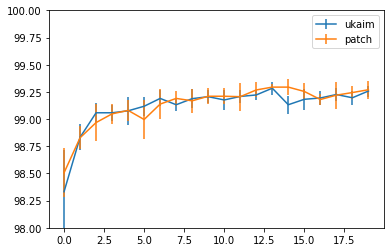

In [42]:
plot_results([avg_accs_sota_ukaim_lr001_results, avg_accs_patchinit_lr001_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_lr001_results, std_accs_patchinit_lr001_results], 98)

## Lr = 0.001

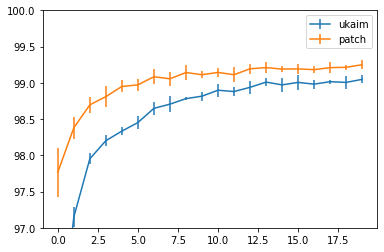

In [43]:
plot_results([avg_accs_sota_ukaim_lr0001_results, avg_accs_patchinit_lr0001_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_lr0001_results, std_accs_patchinit_lr0001_results], 97)

## Lr = 0.0001

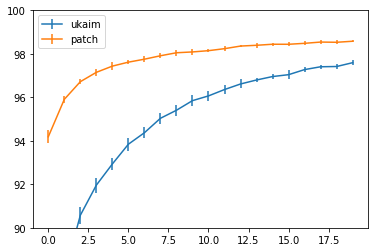

In [44]:
plot_results([avg_accs_sota_ukaim_lr00001_results, avg_accs_patchinit_lr00001_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_lr00001_results, std_accs_patchinit_lr00001_results], 90.)

## Lr = 0.00001

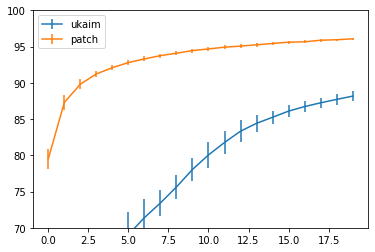

In [45]:
plot_results([avg_accs_sota_ukaim_lr000001_results, avg_accs_patchinit_lr000001_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_lr000001_results, std_accs_patchinit_lr000001_results], 70.)